In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision.datasets import MNIST, FashionMNIST, CIFAR10
from torchvision.transforms import transforms


from lib.custmized_layer import convLayer, poolLayer, denseLayer
from lib.datasets.spikedataset import SpikeDataset, transform_cifar

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# some handy function to use
from lib.utils import save_model, load_dict, load_model, test_method, get_labels

# Test for raw and tailored CNN
Following tasks are done:
1. train and test for MNIST datast with raw_cnn and talor_cnn.
2. the same work for FashionMnist, and with the same set-up for network structure, since the input has the same size, and problems are similar. Besides, we want to show the difference of performance between the 3 networks, raw, tailored and snn with weights from tailored cnn. A network with smaller size can hugely  accelerate this pipeline.
3. 

In [3]:
# set up hyper params
BATCH_SIZE  = 128

EPOCH = 10

NUM_WORKERS = 2

use_cuda = torch.cuda.is_available()

torch.manual_seed(1024)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [4]:
def plot_stats(stats):
    plt.figure(1)
    plt.semilogy(stats.training.lossLog, label='Training')
    plt.semilogy(stats.testing.lossLog, label='Testing')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.figure(2)
    plt.plot(stats.training.accuracyLog, label='Training')
    plt.plot(stats.testing.accuracyLog, label='Testing')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

## Training
def train(model, model_name, trainloader, testloader, criterion, optimizer, stats, epoch):
    
    for epoch in tqdm(range(epoch)):
        # Reset training stats.
        stats.training.reset()
        tSt = datetime.now()
        model.train()    
        # Training loop.
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)

            loss = criterion(outputs, labels)

            loss.backward()

            optimizer.step()

            # Gather training loss stats.
            stats.training.lossSum += loss.cpu().data.item()

            # Gather the training stats.
            _, predicted = torch.max(outputs.data, 1)

            stats.training.correctSamples += torch.sum(predicted == labels).data.item()
            stats.training.numSamples += len(labels)

            # Display training stats.
            # if i%10 == 0: stats.print(epoch, i, (datetime.now() - tSt).total_seconds())
        # Update training stats.
        stats.training.update()
        # Reset testing stats.
        stats.testing.reset()
        model.eval()    
        # Testing loop.
        # Same steps as Training loops except loss backpropagation and weight update.
        for i, data in enumerate(testloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            outputs = model.forward(inputs)
            _, predicted = torch.max(outputs.data, 1)

            stats.testing.correctSamples += torch.sum(predicted == labels).data.item()
            stats.testing.numSamples += len(labels)

            loss = criterion(outputs, labels)
            stats.testing.lossSum += loss.cpu().data.item()


        # Update stats.
        stats.testing.update()
        if epoch%2==0:  stats.print(epoch, timeElapsed=(datetime.now() - tSt).total_seconds())
    print('Finished Training')
    
    test_acc(testloader, model)
    plot_stats(stats)
    save_model(model_name, model)

## Training for CNNs
* define the two CNNs
* define the train function
* train them and check the results

In [4]:
class Raw_CNN_Mnist(nn.Module):
    def __init__(self):
        super(Raw_CNN_Mnist, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, 5, padding=1, bias=True)
        self.conv2 = nn.Conv2d(3, 12, 5, padding=1, bias=True)
        self.m1 = nn.MaxPool2d(2)
        self.m2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(12 * 5 * 5, 10, bias=True)

    def forward(self, x):
        x = F.relu(self.conv1(x)) 
        x = self.m1(x) 
        x = F.relu(self.conv2(x)) 
        x = self.m2(x) 
        x = x.view(-1, 12 * 5 * 5)    
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

class Tailored_CNN_Mnist(nn.Module):
    def __init__(self):
        super(Tailored_CNN_Mnist, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, 5, padding=1, bias=False)
        self.conv2 = nn.Conv2d(3, 12, 5, padding=1, bias=False)
        self.a1 = nn.AvgPool2d(2)
        self.a2 = nn.AvgPool2d(2)
        self.fc1 = nn.Linear(12 * 5 * 5, 10, bias=False)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.a1(x)
        x = F.relu(self.conv2(x))
        x = self.a2(x)
        x = x.view(-1, 12 * 5 * 5)   
        x = self.fc1(x) 
        return F.log_softmax(x, dim=1)
    
# the learningStat class    
class learningStat():
    '''
    This class collect the learning statistics over the epoch.

    Usage:

    This class is designed to be used with learningStats instance although it can be used separately.

    >>> trainingStat = learningStat()
    '''
    def __init__(self):
        self.lossSum = 0
        self.correctSamples = 0
        self.numSamples = 0
        self.minloss = None
        self.maxAccuracy = None
        self.lossLog = []
        self.accuracyLog = []
        self.bestLoss = False
        self.bestAccuracy = False

    def reset(self):
        '''
        Reset the learning staistics. 
        This should usually be done before the start of an epoch so that new statistics counts can be accumulated.

        Usage:

        >>> trainingStat.reset()
        '''
        self.lossSum = 0
        self.correctSamples = 0
        self.numSamples = 0

    def loss(self):
        '''
        Returns the average loss calculated from the point the stats was reset.

        Usage:

        >>> loss = trainingStat.loss()
        '''
        if self.numSamples > 0: 
            return self.lossSum/self.numSamples 
        else:   
            return None

    def accuracy(self):
        '''
        Returns the average accuracy calculated from the point the stats was reset.

        Usage:

        >>> accuracy = trainingStat.accuracy()
        '''
        if self.numSamples > 0 and self.correctSamples > 0:
            return self.correctSamples/self.numSamples  
        else:   
            return None

    def update(self):
        '''
        Updates the stats of the current session and resets the measures for next session.

        Usage:

        >>> trainingStat.update()
        '''
        currentLoss = self.loss()
        self.lossLog.append(currentLoss)
        if self.minloss is None:
            self.minloss = currentLoss
        else:
            if currentLoss < self.minloss:
                self.minloss = currentLoss
                self.bestLoss = True
            else:
                self.bestLoss = False
            # self.minloss = self.minloss if self.minloss < currentLoss else currentLoss

        currentAccuracy = self.accuracy()
        self.accuracyLog.append(currentAccuracy)
        if self.maxAccuracy is None:
            self.maxAccuracy = currentAccuracy
        else:
            if currentAccuracy > self.maxAccuracy:
                self.maxAccuracy = currentAccuracy
                self.bestAccuracy = True
            else:
                self.bestAccuracy = False
            # self.maxAccuracy = self.maxAccuracy if self.maxAccuracy > currentAccuracy else currentAccuracy

    def displayString(self):
        loss = self.loss()
        accuracy = self.accuracy()
        minloss = self.minloss
        maxAccuracy = self.maxAccuracy

        if loss is None:    # no stats available
            return None
        elif accuracy is None: 
            if minloss is None: # accuracy and minloss stats is not available
                return 'loss = %-12.5g'%(loss)
            else:   # accuracy is not available but minloss is available
                return 'loss = %-12.5g (min = %-12.5g)'%(loss, minloss)
        else:
            if minloss is None and maxAccuracy is None: # minloss and maxAccuracy is available
                return 'loss = %-12.5g        %-12s   \taccuracy = %-10.5g        %-10s '%(loss, ' ', accuracy, ' ')
            else:   # all stats are available
                return 'loss = %-12.5g (min = %-12.5g)  \taccuracy = %-10.5g (max = %-10.5g)'%(loss, minloss, accuracy, maxAccuracy)

class learningStats():
    '''
    This class provides mechanism to collect learning stats for training and testing, and displaying them efficiently.

    Usage:

    .. code-block:: python
    
        stats = learningStats()

        for epoch in range(100):
            tSt = datetime.now()

            stats.training.reset()
            for i in trainingLoop:
                # other main stuffs
                stats.training.correctSamples += numberOfCorrectClassification
                stats.training.numSamples     += numberOfSamplesProcessed
                stats.training.lossSum        += currentLoss
                stats.print(epoch, i, (datetime.now() - tSt).total_seconds())
            stats.training.update()

            stats.testing.reset()
            for i in testingLoop
                # other main stuffs
                stats.testing.correctSamples += numberOfCorrectClassification
                stats.testing.numSamples     += numberOfSamplesProcessed
                stats.testing.lossSum        += currentLoss
                stats.print(epoch, i)
            stats.training.update()

    '''
    def __init__(self):
        self.linesPrinted = 0
        self.training = learningStat()
        self.testing  = learningStat()

    def update(self):
        '''
        Updates the stats for training and testing and resets the measures for next session.

        Usage:

        >>> stats.update()
        '''
        self.training.update()
        self.training.reset()
        self.testing.update()
        self.testing.reset()

    def print(self, epoch, iter=None, timeElapsed=None):
        '''
        Prints the available learning statistics from the current session on the console.
        For Linux systems, prints the data on same terminal space (might not work properly on other systems).

        Arguments:
            * ``epoch``: epoch counter to display (required).
            * ``iter``: iteration counter to display (not required).
            * ``timeElapsed``: runtime information (not required).

        Usage:

        .. code-block:: python

            # prints stats with epoch index provided
            stats.print(epoch) 

            # prints stats with epoch index and iteration index provided
            stats.print(epoch, iter=i) 
            
            # prints stats with epoch index, iteration index and time elapsed information provided
            stats.print(epoch, iter=i, timeElapsed=time) 
        '''
        print('\033[%dA'%(self.linesPrinted))
        
        self.linesPrinted = 1

        epochStr   = 'Epoch : %10d'%(epoch)
        iterStr    = '' if iter is None else '(i = %7d)'%(iter)
        profileStr = '' if timeElapsed is None else ', %12.4f ms elapsed'%(timeElapsed * 1000)

        print(epochStr + iterStr + profileStr)
        print(self.training.displayString())
        self.linesPrinted += 2
        if self.testing.displayString() is not None:
            print(self.testing.displayString())
            self.linesPrinted += 1

    def plot(self, figures=(1, 2), saveFig=False, path=''):
        '''
        Plots the available learning statistics.

        Arguments:
            * ``figures``: Index of figure ID to plot on. Default is figure(1) for loss plot and figure(2) for accuracy plot.
            * ``saveFig``(``bool``): flag to save figure into a file.
            * ``path``: path to save the file. Defaule is ``''``.

        Usage:

        .. code-block:: python

            # plot stats
            stats.plot() 

            # plot stats figures specified
            stats.print(figures=(10, 11)) 
        '''
        plt.figure(figures[0])
        plt.cla()
        if len(self.training.lossLog) > 0:
            plt.semilogy(self.training.lossLog, label='Training')
        if len(self.testing.lossLog) > 0:
            plt.semilogy(self.testing .lossLog, label='Testing')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        if saveFig is True: 
            plt.savefig(path + 'loss.png')
            # plt.close()

        plt.figure(figures[1])
        plt.cla()
        if len(self.training.accuracyLog) > 0:
            plt.plot(self.training.accuracyLog, label='Training')
        if len(self.testing.accuracyLog) > 0:
            plt.plot(self.testing .accuracyLog, label='Testing')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend() 
        if saveFig is True: 
            plt.savefig(path + 'accuracy.png')
            # plt.close()

    def save(self, filename=''):
        '''
        Saves the learning satatistics logs.

        Arguments:
            * ``filename``: filename to save the logs. ``accuracy.txt`` and ``loss.txt`` will be appended

        Usage:

        .. code-block:: python

            # save stats
            stats.save() 

            # save stats filename specified
            stats.save(filename='Run101-0.001-') # Run101-0.001-accuracy.txt and Run101-0.001-loss.txt
        '''

        with open(filename + 'loss.txt', 'wt') as loss:
            loss.write('#%11s %11s\r\n'%('Train', 'Test'))
            for i in range(len(self.training.lossLog)): 
                loss.write('%12.6g %12.6g \r\n'%(self.training.lossLog[i], self.testing.lossLog[i]))

        with open(filename + 'accuracy.txt', 'wt') as accuracy:
            accuracy.write('#%11s %11s\r\n'%('Train', 'Test'))
            if self.training.accuracyLog != [None]*len(self.training.accuracyLog):
                for i in range(len(self.training.accuracyLog)): 
                    accuracy.write('%12.6g %12.6g \r\n'%(self.training.accuracyLog[i], self.testing.accuracyLog[i]))

### experiment MNIST

In [6]:
trainset_cnn = MNIST(root='./data', train=True, transform=transforms.Compose([
            transforms.ToTensor()]))

trainloader_cnn = torch.utils.data.DataLoader(trainset_cnn, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=NUM_WORKERS)

testset_cnn = MNIST(root='./data', train=False, transform=transforms.Compose([
            transforms.ToTensor()]))

testloader_cnn = torch.utils.data.DataLoader(testset_cnn, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=NUM_WORKERS)

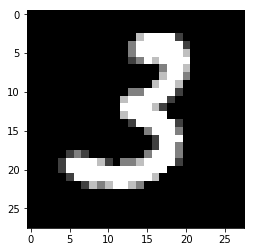

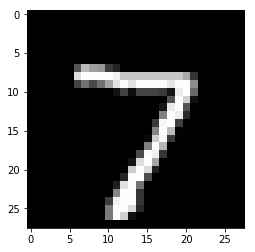

In [7]:
# check if we choose the correct dataset

plt.imshow(next(iter(trainloader_cnn))[0][0].squeeze(), cmap='gray')
plt.show()

plt.imshow(next(iter(testloader_cnn))[0][0].squeeze(), cmap='gray')
plt.show()

* train the raw CNN on MNIST

 10%|█         | 1/10 [00:05<00:51,  5.71s/it]


Epoch :          0,    5711.9190 ms elapsed
loss = 0.0040589    (min = 0.0040589   )  	accuracy = 0.85317    (max = 0.85317   )
loss = 0.0013574    (min = 0.0013574   )  	accuracy = 0.9493     (max = 0.9493    )


 30%|███       | 3/10 [00:16<00:39,  5.61s/it]


Epoch :          2,    5558.3300 ms elapsed
loss = 0.00075866   (min = 0.00075866  )  	accuracy = 0.97083    (max = 0.97083   )
loss = 0.0006046    (min = 0.0006046   )  	accuracy = 0.9752     (max = 0.9752    )


 50%|█████     | 5/10 [00:28<00:28,  5.63s/it]


Epoch :          4,    5678.4440 ms elapsed
loss = 0.00053529   (min = 0.00053529  )  	accuracy = 0.97907    (max = 0.97907   )
loss = 0.00045044   (min = 0.00045044  )  	accuracy = 0.9817     (max = 0.9817    )


 70%|███████   | 7/10 [00:39<00:16,  5.64s/it]


Epoch :          6,    5723.6680 ms elapsed
loss = 0.00043718   (min = 0.00043718  )  	accuracy = 0.98265    (max = 0.98265   )
loss = 0.00043884   (min = 0.00040268  )  	accuracy = 0.981      (max = 0.9829    )


 90%|█████████ | 9/10 [00:50<00:05,  5.72s/it]


Epoch :          8,    5919.5680 ms elapsed
loss = 0.00038116   (min = 0.00038116  )  	accuracy = 0.98512    (max = 0.98512   )
loss = 0.00039225   (min = 0.00039225  )  	accuracy = 0.9842     (max = 0.9842    )


100%|██████████| 10/10 [00:56<00:00,  5.76s/it]

Finished Training


Accuracy of the network: 98 %


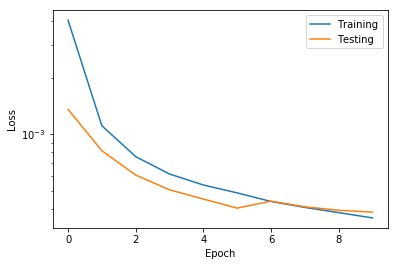

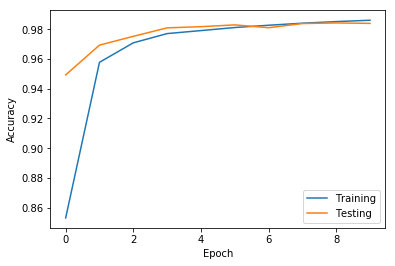

Saving models...


In [10]:
raw_cnn_mnist = Raw_CNN_Mnist().to(device)

raw_criterion = nn.CrossEntropyLoss()
raw_optimizer = optim.Adam(raw_cnn_mnist.parameters(), lr=0.001)
raw_stats = learningStats()

train(raw_cnn_mnist,'raw_cnn_mnist',
      trainloader_cnn,testloader_cnn,
      raw_criterion, 
      raw_optimizer,
      raw_stats,
      epoch=EPOCH)

* The accuracy and confusion matrix

The classification accuracy:  0.9839



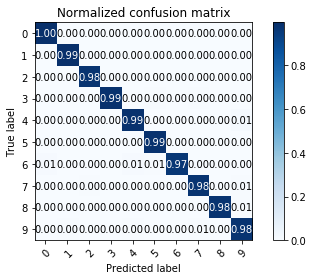

In [9]:
raw_cnn_mnist = Raw_CNN_Mnist().to(device)
load_model('raw_cnn_mnist', raw_cnn_mnist)
y_true, y_pred = get_labels(raw_cnn_mnist, testloader_cnn, snn=False)
test_method(y_true.cpu().numpy(), y_pred.cpu().numpy())

* train the tailored CNN on MNIST

 10%|█         | 1/10 [00:05<00:49,  5.47s/it]


Epoch :          0,    5468.9660 ms elapsed
loss = 0.0044539    (min = 0.0044539   )  	accuracy = 0.84605    (max = 0.84605   )
loss = 0.0017039    (min = 0.0017039   )  	accuracy = 0.9403     (max = 0.9403    )


 30%|███       | 3/10 [00:16<00:38,  5.51s/it]


Epoch :          2,    5485.5120 ms elapsed
loss = 0.00098867   (min = 0.00098867  )  	accuracy = 0.963      (max = 0.963     )
loss = 0.00080162   (min = 0.00080162  )  	accuracy = 0.9691     (max = 0.9691    )


 50%|█████     | 5/10 [00:28<00:28,  5.66s/it]


Epoch :          4,    5600.3100 ms elapsed
loss = 0.00070914   (min = 0.00070914  )  	accuracy = 0.97302    (max = 0.97302   )
loss = 0.00058522   (min = 0.00058522  )  	accuracy = 0.9769     (max = 0.9769    )


 70%|███████   | 7/10 [00:39<00:16,  5.57s/it]


Epoch :          6,    5581.8880 ms elapsed
loss = 0.00058193   (min = 0.00058193  )  	accuracy = 0.97765    (max = 0.97765   )
loss = 0.00054069   (min = 0.00054069  )  	accuracy = 0.979      (max = 0.979     )


 90%|█████████ | 9/10 [00:50<00:05,  5.55s/it]


Epoch :          8,    5570.5730 ms elapsed
loss = 0.00049369   (min = 0.00049369  )  	accuracy = 0.98103    (max = 0.98103   )
loss = 0.00047813   (min = 0.00047384  )  	accuracy = 0.9803     (max = 0.9812    )


100%|██████████| 10/10 [00:55<00:00,  5.51s/it]

Finished Training


Accuracy of the network: 98 %


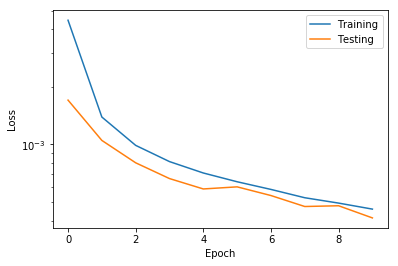

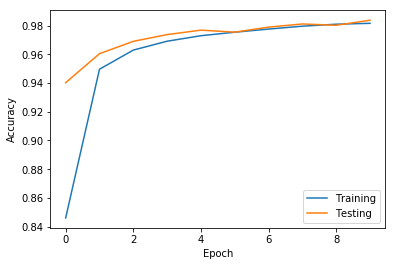

Saving models...


In [11]:
tailored_cnn_mnist = Tailored_CNN_Mnist().to(device)

t_criterion = nn.CrossEntropyLoss()
t_optimizer = optim.Adam(tailored_cnn_mnist.parameters(), lr=0.001)
t_stats = learningStats()

train(tailored_cnn_mnist,'tailor_cnn_mnist', 
      trainloader_cnn,testloader_cnn, 
      t_criterion, 
      t_optimizer,
      t_stats,
      epoch=EPOCH)

* The accuracy and confusion matrix of tailored CNN

The classification accuracy:  0.9838



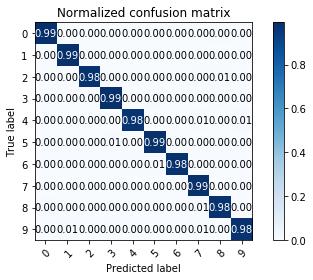

In [11]:
tailored_cnn_mnist = Tailored_CNN_Mnist().to(device)
load_model('tailor_cnn_mnist', tailored_cnn_mnist)
y_true, y_pred = get_labels(tailored_cnn_mnist, testloader_cnn, snn=False)
test_method(y_true.cpu().numpy(), y_pred.cpu().numpy())

### experiment FashionMnist

In [12]:
trainset_cnn = FashionMNIST(root='./data', train=True, transform=transforms.Compose([
            transforms.ToTensor()]))

trainloader_cnn = torch.utils.data.DataLoader(trainset_cnn, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=NUM_WORKERS)

testset_cnn = FashionMNIST(root='./data', train=False, transform=transforms.Compose([
            transforms.ToTensor()]))

testloader_cnn = torch.utils.data.DataLoader(testset_cnn, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=NUM_WORKERS)

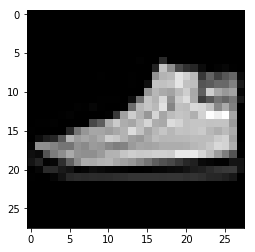

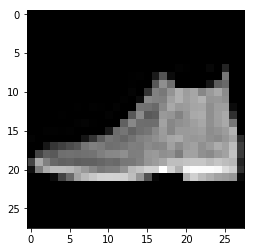

In [13]:
# check if we choose the correct dataset
plt.imshow(next(iter(trainloader_cnn))[0][0].squeeze(), cmap='gray')
plt.show()

plt.imshow(next(iter(testloader_cnn))[0][0].squeeze(), cmap='gray')
plt.show()

  3%|▎         | 1/30 [00:05<02:33,  5.30s/it]


Epoch :          0,    5299.8590 ms elapsed
loss = 0.0062855    (min = 0.0062855   )  	accuracy = 0.72233    (max = 0.72233   )
loss = 0.0045774    (min = 0.0045774   )  	accuracy = 0.7894     (max = 0.7894    )


 10%|█         | 3/30 [00:15<02:20,  5.20s/it]


Epoch :          2,    5136.8770 ms elapsed
loss = 0.0035445    (min = 0.0035445   )  	accuracy = 0.83813    (max = 0.83813   )
loss = 0.0036586    (min = 0.0036586   )  	accuracy = 0.8358     (max = 0.8358    )


 17%|█▋        | 5/30 [00:25<02:10,  5.21s/it]


Epoch :          4,    5275.2230 ms elapsed
loss = 0.003188     (min = 0.003188    )  	accuracy = 0.85527    (max = 0.85527   )
loss = 0.0033011    (min = 0.0033011   )  	accuracy = 0.8502     (max = 0.8502    )


 23%|██▎       | 7/30 [00:36<01:59,  5.19s/it]


Epoch :          6,    5086.1370 ms elapsed
loss = 0.0029933    (min = 0.0029933   )  	accuracy = 0.86407    (max = 0.86407   )
loss = 0.0031342    (min = 0.0031342   )  	accuracy = 0.8608     (max = 0.8608    )


 30%|███       | 9/30 [00:46<01:47,  5.13s/it]


Epoch :          8,    5061.0950 ms elapsed
loss = 0.0028816    (min = 0.0028816   )  	accuracy = 0.86937    (max = 0.86937   )
loss = 0.0030233    (min = 0.0030233   )  	accuracy = 0.8652     (max = 0.8652    )


 37%|███▋      | 11/30 [00:56<01:36,  5.09s/it]


Epoch :         10,    5048.9650 ms elapsed
loss = 0.0027606    (min = 0.0027606   )  	accuracy = 0.87375    (max = 0.87375   )
loss = 0.0029326    (min = 0.0029326   )  	accuracy = 0.8684     (max = 0.8684    )


 43%|████▎     | 13/30 [01:06<01:26,  5.10s/it]


Epoch :         12,    5084.0320 ms elapsed
loss = 0.0026775    (min = 0.0026775   )  	accuracy = 0.87745    (max = 0.87745   )
loss = 0.0029071    (min = 0.0028926   )  	accuracy = 0.8703     (max = 0.8703    )


 50%|█████     | 15/30 [01:17<01:18,  5.20s/it]


Epoch :         14,    5417.2430 ms elapsed
loss = 0.0026285    (min = 0.0026285   )  	accuracy = 0.87998    (max = 0.87998   )
loss = 0.0029079    (min = 0.002888    )  	accuracy = 0.8682     (max = 0.8703    )


 57%|█████▋    | 17/30 [01:27<01:07,  5.20s/it]


Epoch :         16,    5143.7710 ms elapsed
loss = 0.0025423    (min = 0.0025423   )  	accuracy = 0.88248    (max = 0.88248   )
loss = 0.0028581    (min = 0.0027991   )  	accuracy = 0.8708     (max = 0.8744    )


 63%|██████▎   | 19/30 [01:37<00:56,  5.15s/it]


Epoch :         18,    5093.5430 ms elapsed
loss = 0.0024996    (min = 0.0024996   )  	accuracy = 0.8856     (max = 0.8856    )
loss = 0.0028409    (min = 0.0027991   )  	accuracy = 0.8729     (max = 0.8744    )


 70%|███████   | 21/30 [01:48<00:46,  5.21s/it]


Epoch :         20,    5274.5260 ms elapsed
loss = 0.0024481    (min = 0.0024481   )  	accuracy = 0.88745    (max = 0.88745   )
loss = 0.002716     (min = 0.002716    )  	accuracy = 0.8774     (max = 0.8774    )


 77%|███████▋  | 23/30 [01:58<00:36,  5.17s/it]


Epoch :         22,    5060.9420 ms elapsed
loss = 0.0023814    (min = 0.0023814   )  	accuracy = 0.89087    (max = 0.89087   )
loss = 0.0027059    (min = 0.0027059   )  	accuracy = 0.8787     (max = 0.8787    )


 83%|████████▎ | 25/30 [02:08<00:25,  5.08s/it]


Epoch :         24,    5164.9760 ms elapsed
loss = 0.0023414    (min = 0.0023414   )  	accuracy = 0.89263    (max = 0.89263   )
loss = 0.0027631    (min = 0.0027045   )  	accuracy = 0.8772     (max = 0.8787    )


 90%|█████████ | 27/30 [02:19<00:15,  5.13s/it]


Epoch :         26,    5091.0010 ms elapsed
loss = 0.0022979    (min = 0.0022979   )  	accuracy = 0.8945     (max = 0.8945    )
loss = 0.0026369    (min = 0.0026369   )  	accuracy = 0.8831     (max = 0.8831    )


 97%|█████████▋| 29/30 [02:29<00:05,  5.09s/it]


Epoch :         28,    5036.9710 ms elapsed
loss = 0.0022608    (min = 0.0022608   )  	accuracy = 0.89612    (max = 0.89612   )
loss = 0.0026352    (min = 0.0026352   )  	accuracy = 0.8787     (max = 0.8831    )


100%|██████████| 30/30 [02:34<00:00,  5.07s/it]

Finished Training


Accuracy of the network: 88 %


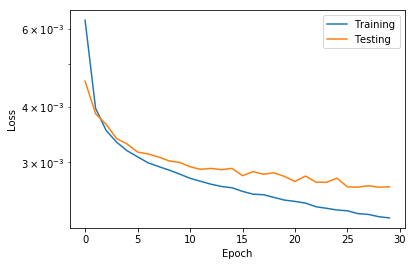

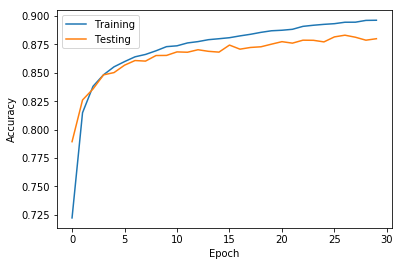

Saving models...


In [14]:
# use the same network structure as for mninst task
raw_cnn_fashion = Raw_CNN_Mnist().to(device)

raw_criterion = nn.CrossEntropyLoss()
raw_optimizer = optim.Adam(raw_cnn_fashion.parameters(), lr=0.001)
raw_stats = learningStats()

train(raw_cnn_fashion,'raw_cnn_fashion',
      trainloader_cnn,testloader_cnn,
      raw_criterion, 
      raw_optimizer,
      raw_stats,
      epoch=EPOCH+20)

The classification accuracy:  0.88



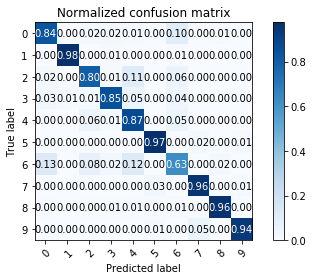

In [14]:
raw_cnn_fashion = Raw_CNN_Mnist().to(device)
load_model('raw_cnn_fashion', raw_cnn_fashion)
y_true, y_pred = get_labels(raw_cnn_fashion, testloader_cnn, snn=False)
test_method(y_true.cpu().numpy(), y_pred.cpu().numpy())

  3%|▎         | 1/30 [00:05<02:26,  5.06s/it]


Epoch :          0,    5057.4160 ms elapsed
loss = 0.0066733    (min = 0.0066733   )  	accuracy = 0.69352    (max = 0.69352   )
loss = 0.0050148    (min = 0.0050148   )  	accuracy = 0.7683     (max = 0.7683    )


 10%|█         | 3/30 [00:15<02:15,  5.02s/it]


Epoch :          2,    4964.5000 ms elapsed
loss = 0.0042098    (min = 0.0042098   )  	accuracy = 0.80855    (max = 0.80855   )
loss = 0.004233     (min = 0.004233    )  	accuracy = 0.8093     (max = 0.8093    )


 17%|█▋        | 5/30 [00:25<02:05,  5.03s/it]


Epoch :          4,    4940.0810 ms elapsed
loss = 0.0037666    (min = 0.0037666   )  	accuracy = 0.82905    (max = 0.82905   )
loss = 0.0038617    (min = 0.0038617   )  	accuracy = 0.8262     (max = 0.8262    )


 23%|██▎       | 7/30 [00:35<01:57,  5.10s/it]


Epoch :          6,    5230.3200 ms elapsed
loss = 0.0035071    (min = 0.0035071   )  	accuracy = 0.84178    (max = 0.84178   )
loss = 0.0036249    (min = 0.0036249   )  	accuracy = 0.8351     (max = 0.8351    )


 30%|███       | 9/30 [00:45<01:45,  5.03s/it]


Epoch :          8,    4860.3040 ms elapsed
loss = 0.003291     (min = 0.003291    )  	accuracy = 0.85273    (max = 0.85273   )
loss = 0.0034276    (min = 0.0034276   )  	accuracy = 0.8506     (max = 0.8506    )


 37%|███▋      | 11/30 [00:55<01:37,  5.11s/it]


Epoch :         10,    5129.2490 ms elapsed
loss = 0.0031157    (min = 0.0031157   )  	accuracy = 0.86028    (max = 0.86028   )
loss = 0.0032761    (min = 0.0032761   )  	accuracy = 0.8551     (max = 0.8551    )


 43%|████▎     | 13/30 [01:05<01:26,  5.10s/it]


Epoch :         12,    5071.7390 ms elapsed
loss = 0.0029691    (min = 0.0029691   )  	accuracy = 0.86705    (max = 0.86705   )
loss = 0.0031271    (min = 0.0031271   )  	accuracy = 0.8644     (max = 0.8644    )


 50%|█████     | 15/30 [01:16<01:16,  5.12s/it]


Epoch :         14,    5139.0570 ms elapsed
loss = 0.002862     (min = 0.002862    )  	accuracy = 0.87132    (max = 0.87132   )
loss = 0.0030489    (min = 0.0030489   )  	accuracy = 0.8657     (max = 0.8657    )


 57%|█████▋    | 17/30 [01:26<01:06,  5.15s/it]


Epoch :         16,    5260.0670 ms elapsed
loss = 0.0027622    (min = 0.0027622   )  	accuracy = 0.87587    (max = 0.87587   )
loss = 0.0029822    (min = 0.0029822   )  	accuracy = 0.8705     (max = 0.8705    )


 63%|██████▎   | 19/30 [01:37<00:57,  5.20s/it]


Epoch :         18,    5351.9770 ms elapsed
loss = 0.0026821    (min = 0.0026821   )  	accuracy = 0.87992    (max = 0.87992   )
loss = 0.0028957    (min = 0.0028957   )  	accuracy = 0.8711     (max = 0.8711    )


 70%|███████   | 21/30 [01:47<00:48,  5.34s/it]


Epoch :         20,    5462.2580 ms elapsed
loss = 0.0026182    (min = 0.0026182   )  	accuracy = 0.8826     (max = 0.8826    )
loss = 0.0029066    (min = 0.0028957   )  	accuracy = 0.8717     (max = 0.8717    )


 77%|███████▋  | 23/30 [01:58<00:36,  5.25s/it]


Epoch :         22,    5147.0280 ms elapsed
loss = 0.0025639    (min = 0.0025639   )  	accuracy = 0.8846     (max = 0.8846    )
loss = 0.0028766    (min = 0.0028441   )  	accuracy = 0.8761     (max = 0.8761    )


 83%|████████▎ | 25/30 [02:08<00:25,  5.16s/it]


Epoch :         24,    5019.8880 ms elapsed
loss = 0.0025135    (min = 0.0025135   )  	accuracy = 0.88673    (max = 0.88673   )
loss = 0.0028524    (min = 0.002822    )  	accuracy = 0.8709     (max = 0.8761    )


 90%|█████████ | 27/30 [02:18<00:15,  5.16s/it]


Epoch :         26,    5205.3930 ms elapsed
loss = 0.002465     (min = 0.002465    )  	accuracy = 0.8888     (max = 0.8888    )
loss = 0.0027658    (min = 0.0027658   )  	accuracy = 0.8761     (max = 0.8763    )


 97%|█████████▋| 29/30 [02:29<00:05,  5.15s/it]


Epoch :         28,    5149.3910 ms elapsed
loss = 0.0024375    (min = 0.0024375   )  	accuracy = 0.88972    (max = 0.88972   )
loss = 0.0028938    (min = 0.0027588   )  	accuracy = 0.8735     (max = 0.8778    )


100%|██████████| 30/30 [02:34<00:00,  5.17s/it]

Finished Training


Accuracy of the network: 87 %


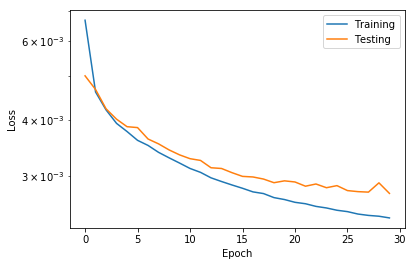

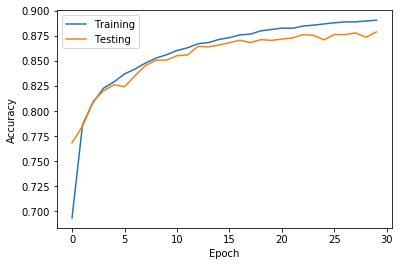

Saving models...


In [15]:
tailored_cnn_fashion = Tailored_CNN_Mnist().to(device)

t_criterion = nn.CrossEntropyLoss()
t_optimizer = optim.Adam(tailored_cnn_fashion.parameters(), lr=0.001)
t_stats = learningStats()

train(tailored_cnn_fashion,'tailor_cnn_fashion', 
      trainloader_cnn,testloader_cnn, 
      t_criterion, 
      t_optimizer,
      t_stats,
      epoch=EPOCH+20)

The classification accuracy:  0.8788



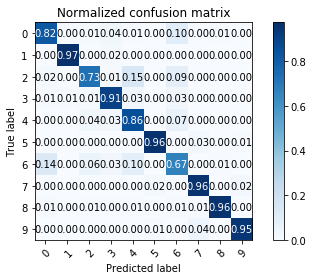

In [15]:
tailored_cnn_fashion = Tailored_CNN_Mnist().to(device)
load_model('tailor_cnn_fashion', tailored_cnn_fashion)
y_true, y_pred = get_labels(tailored_cnn_fashion, testloader_cnn, snn=False)
test_method(y_true.cpu().numpy(), y_pred.cpu().numpy())

# Test for SNN with weights from tailored CNN

## Notes on the conv
* kernel size of time should be 1, otherwise it gets convolved as well.
* bias=False
* replace their pool layer with nn.AvgPool3d. The pool they used is a $sum*\theta$ not an average.
* should recieve the Spikes from the previous layer
* the input value should be within [0,1] before they go into the DataLoader
## Pipeline
raw data(B,C,H,W) --- spike generation ---> spike(B,C,H,W,T) --- Conv3d on spikes ---> X(t) for every t of T --- eq 1: LIF, threshold and reset ---> intermediate V(t), the membrane potential --- based on V(t) ---> Spikes for the next layer.

In [5]:
class custmized_SNN_Mnist(nn.Module):
    
    def __init__(self, thetas, leaks=[0,0,0,0,0], V_mins=[0,0,0,0,0]):
        super(custmized_SNN_Mnist, self).__init__()
        self.conv1 = convLayer(1, 3, 5, theta=thetas[0], padding=1)
        self.pool1 = poolLayer(2, theta=thetas[1])
        self.conv2 = convLayer(3, 12, 5, theta=thetas[2],padding=1)        
        self.pool2 = poolLayer(2, theta=thetas[3])
        self.fc1   = denseLayer((5 * 5 * 12), 10, theta=thetas[4])
        
    def forward(self, spikeInput):
        spike_conv1 = self.conv1(spikeInput)
        #print(spike_conv1)
        spike_pool1 = self.pool1(spike_conv1)
        #print(spike_pool1)
        spike_conv2 = self.conv2(spike_pool1)
        #print(spike_conv2.shape)
        spike_pool2 = self.pool2(spike_conv2)
        spike_for_fc1 = spike_pool2.reshape(-1, 5 * 5 * 12, 1, 1, spike_pool2.shape[-1])
        spikeOut = self.fc1(spike_for_fc1)
        
        return spikeOut

### experiment MNIST

In [6]:
# set up hyper params
TIME_BINS = 100

In [7]:
# Dataset and dataLoader instances.
testingSet_M = SpikeDataset(datasetPath = './data', dataset='mnist',TimeBins=TIME_BINS,
                    small=True, train=False)

testLoader_M = DataLoader(dataset=testingSet_M, batch_size=64, shuffle=False, num_workers=4)

* check the performance of a randomly initialized SNN

In [8]:
thetas = [1, 0.99, 1, 0.99, 1]

custmized_snn_mnist = custmized_SNN_Mnist(thetas=thetas).to(device)

The classification accuracy:  0.112



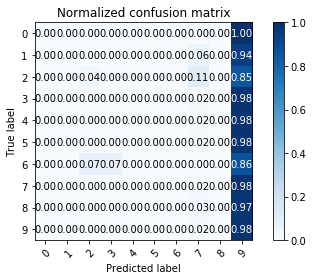

In [9]:
y_true, y_pred = get_labels(custmized_snn_mnist, testLoader_M, snn=True)
test_method(y_true.cpu().numpy(), y_pred.cpu().numpy())

* now try with the weights learned from tailor_cnn

In [10]:
# script to transport the weights
tailor_cnn_weights = load_dict("tailor_cnn_mnist")
snn_weights = custmized_snn_mnist.state_dict()

for k in iter(tailor_cnn_weights):
    print("Layer {}".format(k))
    print(tailor_cnn_weights[k].shape)
    if k.startswith('conv') or k.startswith('fc'):
        snn_weights[k] = tailor_cnn_weights[k].reshape(snn_weights[k].shape)

Layer conv1.weight
torch.Size([3, 1, 5, 5])
Layer conv2.weight
torch.Size([12, 3, 5, 5])
Layer fc1.weight
torch.Size([10, 300])


In [11]:
transformed_snn_mnist = custmized_SNN_Mnist(thetas=thetas).to(device)
transformed_snn_mnist.load_state_dict(snn_weights)

# this warning can be ignored, it happens when using jupyter 
# even the weights are passed without problem

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

The classification accuracy:  0.86



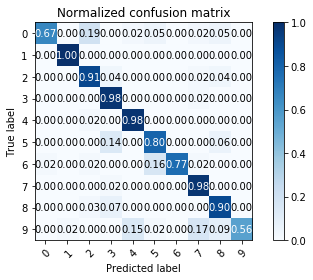

In [12]:
y_true, y_pred = get_labels(transformed_snn_mnist, testLoader_M, snn=True)
test_method(y_true.cpu().numpy(), y_pred.cpu().numpy())

### experiment FashionMnist

In [13]:
testingSet_F = SpikeDataset(datasetPath = './data', dataset='fashion',TimeBins=TIME_BINS,
                    small=False, train=False)
testLoader_F = DataLoader(dataset=testingSet_F, batch_size=64, shuffle=False, num_workers=4)

* check the performance of a randomly initialized SNN

In [15]:
thetas = [10, 0.7, 0.9, 0.7, 1]

custmized_snn_fashion = custmized_SNN_Mnist(thetas=thetas).to(device)

The classification accuracy:  0.1



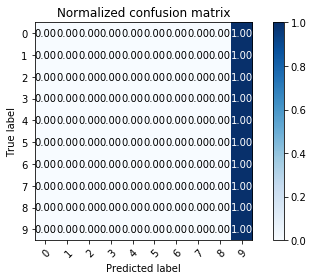

In [16]:
y_true, y_pred = get_labels(custmized_snn_fashion, testLoader_F, snn=True)
test_method(y_true.cpu().numpy(), y_pred.cpu().numpy())

* now try with the weights learned from tailor_cnn

In [17]:
# script to transport the weights
tailor_cnn_weights = load_dict("tailor_cnn_fashion")
snn_weights = transformed_snn_fashion.state_dict()

for k in iter(tailor_cnn_weights):
    print("Layer {}".format(k))
    print(tailor_cnn_weights[k].shape)
    if k.startswith('conv') or k.startswith('fc'):
        snn_weights[k] = tailor_cnn_weights[k].reshape(snn_weights[k].shape)

Layer conv1.weight
torch.Size([3, 1, 5, 5])
Layer conv2.weight
torch.Size([12, 3, 5, 5])
Layer fc1.weight
torch.Size([10, 300])


In [18]:
transformed_snn_fashion = custmized_SNN_Mnist(thetas=thetas).to(device)
transformed_snn_fashion.load_state_dict(snn_weights)

# this warning can be ignored, it happens when using jupyter 
# even the weights are passed without problem

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

The classification accuracy:  0.4866



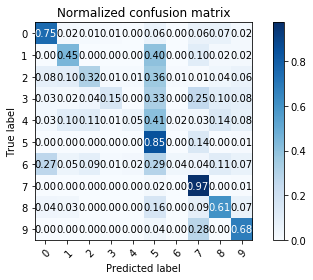

In [19]:
y_true, y_pred = get_labels(transformed_snn_fashion, testLoader_F, snn=True)
test_method(y_true.cpu().numpy(), y_pred.cpu().numpy())